##Importing Libraries

In [ ]:
# Import all the libraries needed
import pandas as pd    # to load dataset
import numpy as np     # for mathematic equation
from nltk.corpus import stopwords   # to get collection of stopwords
from sklearn.model_selection import train_test_split       # for splitting dataset
from tensorflow.keras.preprocessing.text import Tokenizer  # to encode text to int
from tensorflow.keras.preprocessing.sequence import pad_sequences   # to do padding or truncating
from tensorflow.keras.models import Sequential     # the model
from tensorflow.keras.layers import Embedding, LSTM, Dense # layers of the architecture
from tensorflow.keras.callbacks import ModelCheckpoint   # save model
from tensorflow.keras.models import load_model   # load saved model
import re
import matplotlib.pyplot as plt

##DataSet Preview

In [ ]:
# Load data
import pathlib
import pandas as pd
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define file paths
train_path = pathlib.Path('/content/drive/My Drive/CSC4093/phm_train.csv')
test_path = pathlib.Path('/content/drive/My Drive/CSC4093/phm_test.csv')

# Read CSV files
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

# Display data
print(train_data)
print(test_data)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
          tweet_id  label                                              tweet
0     6.430000e+17      0  user_mention all i can tell you is i have had ...
1     6.440000e+17      0  my doctor told me stop he gave me sum pop i mi...
2     8.150000e+17      1  i take tylenol and i wake up in the middle of ...
3     6.820000e+17      0  i got xans in an advil bottle i dont take them...
4     6.440000e+17      1  mom says i need to stop eating so much bc ive ...
...            ...    ...                                                ...
9986  6.480000e+17      1                          that vicodin messed me up
9987  5.710000e+17      0                  user_mention get some tylenol lol
9988  6.470000e+17      0                          like a walking tamiflu ad
9989  6.990000e+17      0                         klay and steph on steroids
9990  8.230000e+17      

## Declaring the english stop words

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
english_stops = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Preprocessing and Encoding labels

In [ ]:
def load_dataset():
    x_train = train_data['tweet']
    y_train = train_data['label']
    x_test = test_data['tweet']
    y_test = test_data['label']

    def preprocess_text(texts):
        texts = texts.replace({'<.*?>': ''}, regex=True)
        texts = texts.replace({'[^A-Za-z]': ' '}, regex=True)
        texts = texts.apply(lambda review: [w for w in review.split() if w not in english_stops])
        texts = texts.apply(lambda review: [w.lower() for w in review])
        return texts

    x_train = preprocess_text(x_train)
    x_test = preprocess_text(x_test)

    y_train = y_train.replace('positive', 1)
    y_train = y_train.replace('negative', 0)
    y_test = y_test.replace('positive', 1)
    y_test = y_test.replace('negative', 0)

    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = load_dataset()
print('x_train', x_train.shape)
print('y_train', y_train.shape)
print('x_test', x_test.shape)
print('y_test', y_test.shape)

x_train (9991,)
y_train (9991,)
x_test (3331,)
y_test (3331,)


## Function for getting the maximum review length

In [ ]:
def get_max_length():
    review_length = []
    for review in x_train:
        review_length.append(len(review))
    return int(np.ceil(np.mean(review_length)))

##Tokenize and Pad/Truncate Reviews

In [ ]:
token = Tokenizer(lower=False)
token.fit_on_texts(x_train)
x_train = token.texts_to_sequences(x_train)
x_test = token.texts_to_sequences(x_test)

max_length = get_max_length()

x_train = pad_sequences(x_train, maxlen=max_length, padding='post', truncating='post')
x_test = pad_sequences(x_test, maxlen=max_length, padding='post', truncating='post')

total_words = len(token.word_index) + 1

print('Encoded X Train\n', x_train, '\n')
print('Encoded X Test\n', x_test, '\n')
print('Maximum review length: ', max_length)

Encoded X Train
 [[    2     1   200 ...   944  3624  1952]
 [  115   122   147 ...   193    40   322]
 [    6     3   330 ...   626  1710    29]
 ...
 [    7   529  1739 ...     0     0     0]
 [12658 12659     8 ...     0     0     0]
 [  645  1436   174 ...     0     0     0]] 

Encoded X Test
 [[  98  606  109 ...  193    4  318]
 [ 585   11   56 ...   16  707   55]
 [ 327   12 1209 ...  778    5   88]
 ...
 [   2    1  126 ...    0    0    0]
 [   2    1    3 ...    0    0    0]
 [  59    8    9 ...    0    0    0]] 

Maximum review length:  10


##Build the model

In [ ]:
EMBED_DIM = 32
LSTM_OUT = 64

model = Sequential()
model.add(Embedding(total_words, EMBED_DIM, input_length = max_length))
model.add(LSTM(LSTM_OUT))
model.add(Dense(1, activation='sigmoid'))

model.build(input_shape=(None, max_length))
print(model.summary())

#Set HyperParameters
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_16 (Embedding)        │ (None, 10, 32)         │       405,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 430,017 (1.64 MB)

 Trainable params: 430,017 (1.64 MB)

 Non-trainable params: 0 (0.00 B)

None


##Model Training

In [ ]:
checkpoint = ModelCheckpoint(
    'models/LSTM_phm.h5',
    monitor='accuracy',
    save_best_only=True,
    verbose=1
)

In [ ]:
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=128,
    epochs=5,
    callbacks=[checkpoint],
    verbose=1
)

Epoch 1/5
77/79 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7009 - loss: 0.6168
Epoch 1: accuracy improved from -inf to 0.73596, saving model to models/LSTM_phm.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.7023 - loss: 0.6145 - val_accuracy: 0.8046 - val_loss: 0.4349
Epoch 2/5
77/79 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8356 - loss: 0.3813
Epoch 2: accuracy improved from 0.73596 to 0.84056, saving model to models/LSTM_phm.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8358 - loss: 0.3809 - val_accuracy: 0.8226 - val_loss: 0.3974
Epoch 3/5
77/79 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8939 - loss: 0.2705
Epoch 3: accuracy improved from 0.84056 to 0.88380, saving model to models/LSTM_phm.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.8935 - loss: 0.2710 - val_accuracy: 0.8217 - val_loss: 0.4136
Epoch 4/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9107 - loss: 0.2206
Epoch 4: accuracy improved from 0.88380 to 0.90982, saving model to models/LSTM_phm.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9107 - loss: 0.2207 - val_accuracy: 0.8154 - val_loss: 0.4598
Epoch 5/5
76/79 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9325 - loss: 0.1775
Epoch 5: accuracy improved from 0.90982 to 0.93004, saving model to models/LSTM_phm.h5


79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9324 - loss: 0.1779 - val_accuracy: 0.8142 - val_loss: 0.4791


##Single LSTM Model Testing

In [ ]:
pred = model.predict(x=x_test)
y_pred = (pred >= 0.5) * 1

#y_pred = model.predict(x_test)

true = 0
for i, y in enumerate(y_test):
    if y == y_pred[i]:
        true += 1


print('Correct Prediction: {}'.format(true))
print('Wrong Prediction: {}'.format(len(y_pred) - true))
print('Accuracy: {}'.format(true/len(y_pred)*100))
print(model.summary())

105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Correct Prediction: 2712
Wrong Prediction: 619
Accuracy: 81.41699189432603


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_16 (Embedding)        │ (None, 10, 32)         │       405,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,290,053 (4.92 MB)

 Trainable params: 430,017 (1.64 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 860,036 (3.28 MB)

None


##Visualization

Test Accuracy: 81.42%
Test Loss: 0.4791


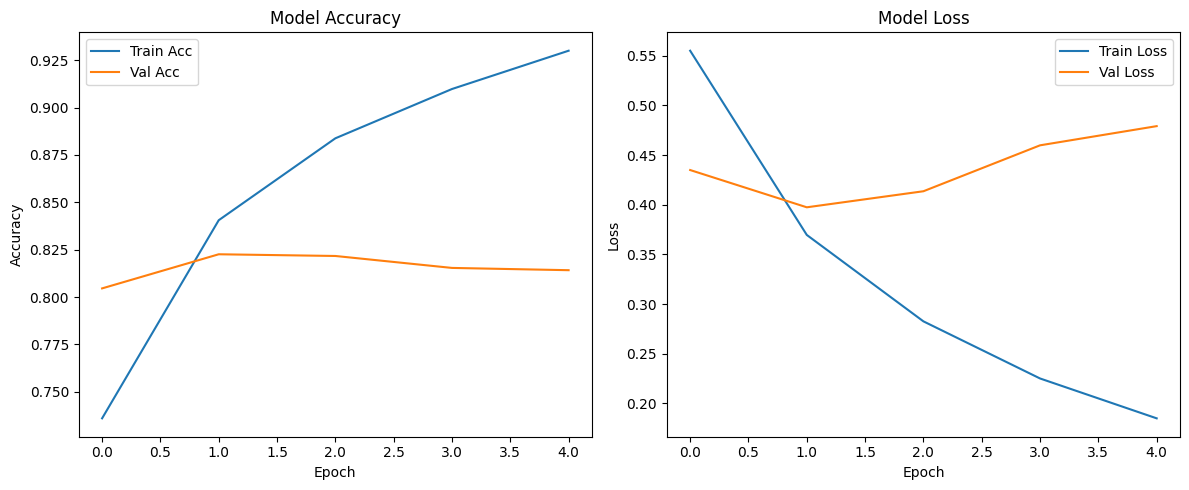

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Test Loss: {loss:.4f}")

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()